In [52]:
# Standard library imports
import os
import sys
import time
from itertools import combinations

# Numerical and Scientific Libraries
import numpy as np
from scipy import signal, linalg
from scipy.interpolate import splrep, BSpline
from scipy.stats import loguniform
from scipy.ndimage import convolve

# Astropy Modules
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import sigma_clipped_stats
from astropy.time import Time
from astropy import constants, cosmology, units as u

# Photutils Modules
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, deblend_sources
from photutils.background import Background2D, MedianBackground, SExtractorBackground

# Machine Learning and Gaussian Processes
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.kernel_ridge import KernelRidge
import GPy
import emcee

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, HTML

# LAL Modules
from lal import gpstime

# NFFT for Fourier Transforms
import nfft

# Astropy Cosmology
from astropy.cosmology import Planck18, FlatLambdaCDM

# Plotting configuration
mpl.rcParams.update({
    'text.usetex': True,
    'xtick.major.size': 8,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.minor.size': 4,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.3,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.3,
    'patch.linewidth': 1.3,
    'axes.linewidth': 2
})

# Set environment variables
os.environ["OMP_NUM_THREADS"] = "1"

# Display settings for Jupyter Notebooks
display(HTML("<style>.container { width:100% !important; }</style>"))

# Add custom module paths
sys.path.insert(1, '../../milestone2/bispec_phase/scripts/notebooks/')


In [53]:
data_path = '/media/himanshu/MyHDD/data_galaxy_evolution/data/'  # path to HST-JWST fits images
# loading EELGS and control galaxy samples
catalog = data_path + 'sample_details/'
eelgs = catalog + 'eelgs_28aug2024.dat'
control = catalog + 'control_28aug2024.dat'

In [54]:
c0 = fits.open(data_path+'/catalog/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v2.0_catalog.fits')
c1 = fits.open(data_path+'/catalog/hlsp_jades_jwst_nirspec_goods-s-deephst_clear-prism_line-fluxes_v1.0_catalog.fits')
c2 = fits.open(data_path+'/catalog/hlsp_jades_jwst_nirspec_goods-s-deephst_gratings_line-fluxes_v1.0_catalog.fits')
c3 = fits.open(data_path+'/catalog/hlsp_jades_jwst_nirspec_goods-s_gratings-line-fluxes_v1.1_catalog.fits')
c4 = fits.open(data_path+'/catalog/hlsp_jades_jwst_nirspec_goods-s_prism-line-fluxes_v1.1_catalog.fits')

In [55]:
# extracting sample data : id, ra, dec, photo_z, spec_z
use_control = True
if use_control == True:
    data_columns = np.loadtxt(control, dtype='str', delimiter=',')[0]
    sample_data  = np.loadtxt(control, delimiter=',', skiprows=1)
else:
    
    data_columns = np.loadtxt(eelgs, dtype='str', delimiter=',')[0]
    sample_data  = np.loadtxt(eelgs, delimiter=',', skiprows=1)
    
new_dtype = [(name, float) for name in data_columns]
sample_data = np.array([tuple(row) for row in sample_data], dtype=new_dtype)

In [5]:
# data selection for high redshift
ind = np.where(sample_data['zspec'] > 3.08)
#if use_control == True:
#    ra, dec, zspec = sample_data['RA'][ind], sample_data['dec'][ind], sample_data['zspec'][ind]
#else:
#    ra, dec, zspec = sample_data['RA'.lower()][ind], sample_data['dec'][ind], sample_data['zspec'][ind]
#    
sample_data = sample_data[ind]

In [6]:
offset = 0.3*u.arcsecond
offset = offset.to(u.deg)

In [7]:
sample_data['dec'] = sample_data['dec'] - offset.value

In [8]:
# loading fits files for two filters, e.g. first non-ionizing filter (base filter), second ionizing filter

def load_fits(filt0, filt1):
    '''
    filt0: name of the filter
    
    filt1: name of the filter
    
    returns: fits filters and weights
    '''
    fitsfile0     = data_path  + 'hlsp_fresco_hst_acs-wfc_goods-s_%s_v1.0_sci.fits'%filt0
    fitsfile_wts0 = data_path  + 'hlsp_fresco_hst_acs-wfc_goods-s_%s_v1.0_wht.fits'%filt0
    fitsfile1     = data_path  + 'hlsp_fresco_hst_wfc3-uvis_goods-s_%s_v1.0_sci.fits'%filt1
    fitsfile_wts1 = data_path  + 'hlsp_fresco_hst_wfc3-uvis_goods-s_%s_v1.0_wht.fits'%filt1
    
    return fitsfile0, fitsfile_wts0, fitsfile1, fitsfile_wts1

In [9]:
filt0='f814w' # non-ionizing filter
filt1='f336w' # ionizing filter
fitsfile0, fitsfile_wts0, fitsfile1, fitsfile_wts1 = load_fits(filt0='f814w', filt1='f336w')

In [10]:
#loading the filters
f0  = fits.open(fitsfile0)
fw0 = fits.open(fitsfile_wts0)

f1  = fits.open(fitsfile1)
fw1 = fits.open(fitsfile_wts1)

flux_units = f0[0].header['bunit']
# Check if FILTER2 or FILTER is present in the header
if 'FILTER2' in f0[0].header or 'FILTER' in f[0].header:
    # Access the filters, defaulting to empty string if not present
    filter2 = f0[0].header.get('FILTER2', '')
    filter1 = f0[0].header.get('FILTER', '')

    # Determine the filter that starts with 'F'
    filt = filter2 if filter2.startswith('F') else (filter1 if filter1.startswith('F') else None)
    
    if filt:
        print(f"Selected Filter: {filt}")
    else:
        print("No filter starts with 'F'.")
else:
    print("Neither FILTER2 nor FILTER is present in the header.")


Selected Filter: F814W


In [11]:
wcs = WCS(f0[0]) #wcs of the filter

In [12]:
sample_data.shape

(90,)

In [13]:
## concatanating the 3 rounds of segmentations

In [14]:
good_indices             =[]
mask_arr                 =[]
wcs_filt0_arr            =[]
wcs_filt1_arr            =[]
img_only_noise_filt0_arr =[]
img_with_source_filt0_arr=[]
img_with_source_wts0_arr =[]
img_only_noise_wts0_arr  =[]
img_only_noise_filt1_arr =[]
img_with_source_filt1_arr=[]
img_with_source_wts1_arr =[]
img_only_noise_wts1_arr  =[]

for rounds in range(1,3):
    
    mask_arr_                  = np.load('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/mask_arr_'                 + '%d.npy'%rounds, allow_pickle=True)
    good_index                 = np.load('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/good_index'                + '%d.npy'%rounds                   )
    
    wcs_filt0_arr_             = np.load('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/wcs_filt0_arr_'            + '%d.npy'%rounds, allow_pickle=True)
    wcs_filt1_arr_             = np.load('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/wcs_filt1_arr_'            + '%d.npy'%rounds, allow_pickle=True)
    
    img_with_source_filt0_arr_ = np.load('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_filt0_arr_'+ '%d.npy'%rounds, allow_pickle=True)
    img_with_source_filt1_arr_ = np.load('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_filt1_arr_'+ '%d.npy'%rounds, allow_pickle=True)
    
    img_only_noise_filt0_arr_  = np.load('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_only_noise_filt0_arr_' + '%d.npy'%rounds, allow_pickle=True)
    img_only_noise_filt1_arr_  = np.load('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_only_noise_filt1_arr_' + '%d.npy'%rounds, allow_pickle=True)
        
    img_with_source_wts0_arr_  = np.load('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_wts0_arr_2_' + '%d.npy'%rounds, allow_pickle=True)
    img_with_source_wts1_arr_  = np.load('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_with_source_wts1_arr_2_' + '%d.npy'%rounds, allow_pickle=True)
    
    img_only_noise_wts0_arr_   = np.load('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_only_noise_wts0_arr_'  + '%d.npy'%rounds, allow_pickle=True)
    img_only_noise_wts1_arr_   = np.load('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/img_only_noise_wts1_arr_'  + '%d.npy'%rounds, allow_pickle=True)
    
    print(good_index.shape, mask_arr_.shape)

    mask_arr                 .append(mask_arr_                 )
    good_indices             .append(good_index                )

    wcs_filt0_arr            .append(wcs_filt0_arr_            )
    wcs_filt1_arr            .append(wcs_filt1_arr_            )
    
    img_with_source_filt0_arr.append(img_with_source_filt0_arr_)
    img_with_source_filt1_arr.append(img_with_source_filt1_arr_)

    img_only_noise_filt0_arr .append(img_only_noise_filt0_arr_ )
    img_only_noise_filt1_arr .append(img_only_noise_filt1_arr_ )
    
    img_with_source_wts0_arr .append(img_with_source_wts0_arr_ )
    img_with_source_wts1_arr .append(img_with_source_wts1_arr_ )

    img_only_noise_wts0_arr  .append(img_only_noise_wts0_arr_  )
    img_only_noise_wts1_arr  .append(img_only_noise_wts1_arr_  )


good_indices             = np.concatenate(good_indices)   
good_indices_argsort     = np.argsort(good_indices)
mask_arr                 = np.concatenate(mask_arr                 )
wcs_filt0_arr            = np.concatenate(wcs_filt0_arr            )
wcs_filt1_arr            = np.concatenate(wcs_filt1_arr            )
img_only_noise_filt0_arr = np.concatenate(img_only_noise_filt0_arr )
img_with_source_filt0_arr= np.concatenate(img_with_source_filt0_arr)
img_with_source_wts0_arr = np.concatenate(img_with_source_wts0_arr )
img_only_noise_wts0_arr  = np.concatenate(img_only_noise_wts0_arr  )
img_only_noise_filt1_arr = np.concatenate(img_only_noise_filt1_arr )
img_with_source_filt1_arr= np.concatenate(img_with_source_filt1_arr)
img_with_source_wts1_arr = np.concatenate(img_with_source_wts1_arr )
img_only_noise_wts1_arr  = np.concatenate(img_only_noise_wts1_arr  )

(60,) (60, 125, 125)
(22,) (22, 125, 125)


In [15]:
good_indices.shape, wcs_filt1_arr.shape, img_only_noise_filt0_arr.shape

((82,), (82,), (82, 125, 125))

In [16]:
wcs_filt0_arr            = wcs_filt0_arr            [good_indices_argsort]
mask_arr                 = mask_arr                 [good_indices_argsort]
wcs_filt1_arr            = wcs_filt1_arr            [good_indices_argsort]
img_only_noise_filt0_arr = img_only_noise_filt0_arr [good_indices_argsort]
img_with_source_filt0_arr= img_with_source_filt0_arr[good_indices_argsort]
img_with_source_wts0_arr = img_with_source_wts0_arr [good_indices_argsort]
img_only_noise_wts0_arr  = img_only_noise_wts0_arr  [good_indices_argsort]
img_only_noise_filt1_arr = img_only_noise_filt1_arr [good_indices_argsort]
img_with_source_filt1_arr= img_with_source_filt1_arr[good_indices_argsort]
img_with_source_wts1_arr = img_with_source_wts1_arr [good_indices_argsort]
img_only_noise_wts1_arr  = img_only_noise_wts1_arr  [good_indices_argsort]
good_indices             = good_indices             [good_indices_argsort]

In [17]:
good_segmentation_index = np.array([1, 2, 4, 5, 6, 7, 10,11,13,14,15,16,17,19,21, 
                                    22,24,25,27,28,29,30,31,34,35,36,37,39,40,41,43,44,45,46,47,48,
                                   49,50,54,55,56,57,58,59,64,65,66,68,70,71,72,73,76,
                                   77,78,79,80,81,82,83]) -1

In [18]:
err_ind  = np.array([ 2, 35, 41, 48, 49, 88, 89])
good_ind = np.array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87])

In [19]:
good_ind.shape, sample_data.shape

((83,), (90,))

In [20]:
sample_data = sample_data[good_ind]

In [21]:
tol = 0.0003
if use_control == True:
    cat_indx_match = np.load('cat_matching_index_tol_control_%s.npy'%tol, allow_pickle=True)
else:
    cat_indx_match = np.load('cat_matching_index_tol_eelgs_%s.npy'%tol, allow_pickle=True)
    
catalog_ids = c0[-1].data['ID']
phot_z      = c0[-1].data['EAZY_z_a']
z_68l       = c0[-1].data['EAZY_l68']
z_68u       = c0[-1].data['EAZY_u68']
z_95l       = c0[-1].data['EAZY_l95']
z_95u       = c0[-1].data['EAZY_u95']
z_99l       = c0[-1].data['EAZY_l99']
z_99u       = c0[-1].data['EAZY_u99']
#control_ids = data['id'].astype(int)
#ind_ = np.where((z_99u - z_99l) < 0.2)[0]
#

#phot_z_arr= []
#z_68l_arr = []
#z_68u_arr = []
#z_95l_arr = []
#z_95u_arr = []
#z_99l_arr = []
#z_99u_arr = []
#for i in range(len(c0[-1].data['ID'])):
#    #catalog_ids = catalog_ids[ind_]
#    
#    try:
#        #print(int(predicted_match[i][0]))
#        phot_z_arr     .append(phot_z     [int(predicted_match[i][0])])
#        z_68l_arr      .append(z_68l      [int(predicted_match[i][0])])
#        z_68u_arr      .append(z_68u      [int(predicted_match[i][0])])
#        z_95l_arr      .append(z_95l      [int(predicted_match[i][0])])
#        z_95u_arr      .append(z_95u      [int(predicted_match[i][0])])
#        z_99l_arr      .append(z_99l      [int(predicted_match[i][0])])
#        z_99u_arr      .append(z_99u      [int(predicted_match[i][0])])
#    except:
#        #print(predicted_match[i][0])
#        pass
#phot_z_arr = np.array(phot_z_arr)
#z_68l_arr  = np.array(z_68l_arr )
#z_68u_arr  = np.array(z_68u_arr )
#z_95l_arr  = np.array(z_95l_arr )
#z_95u_arr  = np.array(z_95u_arr )
#z_99l_arr  = np.array(z_99l_arr )
#z_99u_arr  = np.array(z_99u_arr )

if len(err_ind) != 0:
    cat_indx_match = np.delete(cat_indx_match, err_ind, axis=0)
    bad_indx_eelgs= np.array([11, 24]) # control sample
bad_indx_ctrl = np.array([5, 25, 45, 54, 59, 60, 73, 81]) # control sample

# Set up a grid of 27 rows and 3 columns
fig, axes = plt.subplots(nrows=len(img_only_noise_filt0_arr), ncols=3, figsize=(15, len(img_only_noise_filt0_arr) * 5))

good_segmentation_index = good_indices

# Adjust spacing between subplots
fig.subplots_adjust(hspace=.3, wspace=.3)

# Loop through each set of images and plot them in the corresponding row
for i in range(good_segmentation_index.size):
    if not use_control:
        coordinates = SkyCoord(ra=sample_data['ra'][good_ind[good_segmentation_index[i]]], dec=sample_data['dec'][good_ind[good_segmentation_index[i]]], unit="deg")
        s_ID = sample_data['id'][good_ind[good_segmentation_index[i]]]
    else:
        coordinates = SkyCoord(ra=sample_data['RA'][good_ind[good_segmentation_index[i]]], dec=sample_data['dec'][good_ind[good_segmentation_index[i]]], unit="deg")
        s_ID = sample_data['id'][good_ind[good_segmentation_index[i]]]
    # Convert world coordinates to pixel coordinates
    pixel_coords = wcs_filt0_arr[i].wcs.world_to_pixel(coordinates)
    # Check for matched catalog indices
    if len(cat_indx_match[i]) != 0:
        ra_s, dec_s = c0[2].data[cat_indx_match[i][0]]['ra'], c0[2].data[cat_indx_match[i][0]]['dec']
        coordinates_s = SkyCoord(ra=ra_s, dec=dec_s, unit="deg")
        pixel_coords_s = wcs_filt0_arr[i].wcs.world_to_pixel(coordinates_s)
        phot_zz = c0[-1].data[cat_indx_match[i][0]]['EAZY_z_a']
        z99ll = z_99l[cat_indx_match[i][0]]
        z99ul = z_99u[cat_indx_match[i][0]]

    # Plot the first image (data_sub_arr) in the left column
    # Plot the third image (segment_map_arr) in the right column
    ax0 = plt.subplot(len(img_only_noise_filt0_arr), 3, 3 * i + 1, projection=wcs_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax0.imshow(wcs_filt0_arr[i].data, origin='lower', vmax=0.1, vmin=-0.1, cmap='cividis', alpha=0.7)
    ax0.set_xlabel('RA [hms]')
    ax0.set_ylabel('DEC [dms]', visible=False)
    #ax0.set_title(f"remaining Segments {i + 1}")
    
    
    # Plot matched catalog sources if they exist
    if len(cat_indx_match[i]) != 0:
        for indd in range(len(z99ul)):
            ax0.plot(
                pixel_coords_s[0][indd], pixel_coords_s[1][indd], 'd', markersize=5,
                label=rf'$\rm JADES-z={phot_zz[indd]:.3f}, {z99ll[indd]:.3f}< z_{{99\%}}^{{CI}}<{z99ul[indd]:.3f}$'
            )

    # Add legend to the subplot
    ax0.legend(fontsize=8, framealpha=0)
    ax0.set_title(f"All Sources")
    
    # Plot the second image (background_filled_arr) in the middle column
    ax1 = plt.subplot(len(img_only_noise_filt0_arr), 3, 3 * i + 2, projection=wcs_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax1.imshow(img_with_source_filt0_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7, aspect='equal')
    ax1.set_xlabel('RA [hms]')
    ax1.set_ylabel('DEC [dms]')
    ax1.plot(pixel_coords[0], pixel_coords[1], 'go', markersize=5, label=rf'$\rm zfourge-z={sample_data["zphot"][good_ind[i]]}$')
    ax1.set_title("Only Source-%d"%s_ID)


    
    ax2 = plt.subplot(len(img_only_noise_filt0_arr), 3, 3 * i + 3, projection=wcs_filt0_arr[i].wcs)  # Set WCS for this subplot
    ax2.imshow(img_only_noise_filt0_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7)
    ax2.set_xlabel('RA [hms]')
    ax2.set_ylabel('DEC [dms]', visible=False)
    ax2.set_title("Background")
    
    
    
    # Add a color bar for each subplot
    cbar0 = plt.colorbar(ax0.images[0], ax=ax0, fraction=0.046, pad=0.04)
    cbar0.set_label('Flux Density [%s]' % flux_units)

    cbar1 = plt.colorbar(ax1.images[0], ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('Flux Density [%s]' % flux_units)

    cbar2 = plt.colorbar(ax2.images[0], ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label('Flux Density [%s]' % flux_units)


if use_control:
    plt.savefig(f'source_z_mask_control_cut_seg_rem_src_{filt0}FINAL.jpg')
else:
    plt.savefig(f'source_z_mask_eelgs_cut_seg_rem_src_{filt0}FINAL.jpg')

    
plt.show()


# Set up a grid of 27 rows and 3 columns
fig, axes = plt.subplots(nrows=len(img_only_noise_filt1_arr), ncols=3, figsize=(15, len(img_only_noise_filt1_arr) * 5))

good_segmentation_index = good_indices

# Adjust spacing between subplots
fig.subplots_adjust(hspace=.3, wspace=.3)

# Loop through each set of images and plot them in the corresponding row
for i in range(good_segmentation_index.size):
    if not use_control:
        coordinates = SkyCoord(ra=sample_data['ra'][good_ind[good_segmentation_index[i]]], dec=sample_data['dec'][good_ind[good_segmentation_index[i]]], unit="deg")
        s_ID = sample_data['id'][good_ind[good_segmentation_index[i]]]
    else:
        coordinates = SkyCoord(ra=sample_data['RA'][good_ind[good_segmentation_index[i]]], dec=sample_data['dec'][good_ind[good_segmentation_index[i]]], unit="deg")
        s_ID = sample_data['id'][good_ind[good_segmentation_index[i]]]

    # Convert world coordinates to pixel coordinates
    pixel_coords = wcs_filt1_arr[i].wcs.world_to_pixel(coordinates)

    # Check for matched catalog indices
    if len(cat_indx_match[i]) != 0:
        ra_s, dec_s = c0[2].data[cat_indx_match[i][0]]['ra'], c0[2].data[cat_indx_match[i][0]]['dec']
        coordinates_s = SkyCoord(ra=ra_s, dec=dec_s, unit="deg")
        pixel_coords_s = wcs_filt1_arr[i].wcs.world_to_pixel(coordinates_s)
        phot_zz = c0[-1].data[cat_indx_match[i][0]]['EAZY_z_a']
        z99ll = z_99l[cat_indx_match[i][0]]
        z99ul = z_99u[cat_indx_match[i][0]]

    # Plot the first image (data_sub_arr) in the left column
    # Plot the third image (segment_map_arr) in the right column
    ax0 = plt.subplot(len(img_only_noise_filt1_arr), 3, 3 * i + 1, projection=wcs_filt1_arr[i].wcs)  # Set WCS for this subplot
    ax0.imshow(wcs_filt1_arr[i].data, origin='lower', vmax=0.1, vmin=-0.1, cmap='cividis', alpha=0.7)
    ax0.set_xlabel('RA [hms]')
    ax0.set_ylabel('DEC [dms]', visible=False)
    #ax0.set_title(f"remaining Segments {i + 1}")
    
    
    # Plot matched catalog sources if they exist
    if len(cat_indx_match[i]) != 0:
        for indd in range(len(z99ul)):
            ax0.plot(
                pixel_coords_s[0][indd], pixel_coords_s[1][indd], 'd', markersize=5,
                label=rf'$\rm JADES-z={phot_zz[indd]:.3f}, {z99ll[indd]:.3f}< z_{{99\%}}^{{CI}}<{z99ul[indd]:.3f}$'
            )

    # Add legend to the subplot
    ax0.legend(fontsize=8, framealpha=0)
    ax0.set_title(f"All Sources")
    
    # Plot the second image (background_filled_arr) in the middle column
    ax1 = plt.subplot(len(img_only_noise_filt1_arr), 3, 3 * i + 2, projection=wcs_filt1_arr[i].wcs)  # Set WCS for this subplot
    ax1.imshow(img_with_source_filt1_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7, aspect='equal')
    ax1.set_xlabel('RA [hms]')
    ax1.set_ylabel('DEC [dms]')
    ax1.plot(pixel_coords[0], pixel_coords[1], 'go', markersize=5, label=rf'$\rm zfourge-z={sample_data["zphot"][good_ind[i]]}$')
    ax1.set_title("Only Source-%d"%s_ID)

    
    ax2 = plt.subplot(len(img_only_noise_filt1_arr), 3, 3 * i + 3, projection=wcs_filt1_arr[i].wcs)  # Set WCS for this subplot
    ax2.imshow(img_only_noise_filt1_arr[i], vmax=0.1, vmin=-0.1, origin='lower', cmap='cividis', alpha=0.7)
    ax2.set_xlabel('RA [hms]')
    ax2.set_ylabel('DEC [dms]', visible=False)
    ax2.set_title("Background")
    
    
    
    # Add a color bar for each subplot
    cbar0 = plt.colorbar(ax0.images[0], ax=ax0, fraction=0.046, pad=0.04)
    cbar0.set_label('Flux Density [%s]' % flux_units)

    cbar1 = plt.colorbar(ax1.images[0], ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('Flux Density [%s]' % flux_units)

    cbar2 = plt.colorbar(ax2.images[0], ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label('Flux Density [%s]' % flux_units)


if use_control:
    plt.savefig(f'source_z_mask_control_cut_seg_rem_src_{filt1}FINAL.jpg')
else:
    plt.savefig(f'source_z_mask_eelgs_cut_seg_rem_src_{filt1}FINAL.jpg')

    
plt.show()


In [22]:
def crop_image_centered_on_peak(image_data, wcs, crop_size_arcsec=2.0):
    """
    Finds the peak flux in an image, centres the image around the peak flux,
    and crops a square region of the given size in arcseconds. Returns the
    cropped image, cropped WCS, peak flux coordinates, and the cropping indices.

    Parameters:
        image_data (numpy.ndarray): 2D array of image data.
        wcs (astropy.wcs.WCS): WCS object for the image.
        crop_size_arcsec (float): Size of the cropped region in arcseconds (default: 2 arcseconds).

    Returns:
        cropped_image (numpy.ndarray): Cropped image array.
        cropped_wcs (astropy.wcs.WCS): Cropped WCS object.
        peak_coords (SkyCoord): SkyCoord object of the peak flux in world coordinates.
        indices_range (tuple): Indices range of the cropped region ((y_min, y_max), (x_min, x_max)).
    """
    # Find the pixel coordinates of the peak flux
    peak_y, peak_x = np.unravel_index(np.argmax(image_data), image_data.shape)
    
    # Convert pixel coordinates to world coordinates
    peak_coords = wcs.pixel_to_world(peak_x, peak_y)
    
    # Calculate the crop size in pixels
    pixel_scale = np.abs(wcs.pixel_scale_matrix[0, 0]) * 3600  # Pixel scale in arcsec/pixel
    crop_size_pixels = int(np.round(crop_size_arcsec / pixel_scale))
    
    # Define the crop boundaries
    y_min = max(0, peak_y - crop_size_pixels // 2)
    y_max = min(image_data.shape[0], peak_y + crop_size_pixels // 2)
    x_min = max(0, peak_x - crop_size_pixels // 2)
    x_max = min(image_data.shape[1], peak_x + crop_size_pixels // 2)
    
    # Crop the image
    cropped_image = image_data[y_min:y_max, x_min:x_max]
    
    # Adjust WCS for the cropped region
    cropped_wcs = wcs.deepcopy()
    cropped_wcs.wcs.crpix[0] -= x_min
    cropped_wcs.wcs.crpix[1] -= y_min
    
    # Indices range
    indices_range = ((y_min, y_max), (x_min, x_max))
    
    return cropped_image, cropped_wcs, peak_coords, indices_range

def find_peak_pixel(image_data):
    """
    Finds the peak pixel value and its coordinates in a 2D image array.

    Parameters:
        image_data (numpy.ndarray): 2D array of image data.

    Returns:
        peak_value (float): The peak pixel value in the image.
        peak_coords (tuple): Coordinates of the peak pixel (y, x).
    """
    # Find the coordinates of the maximum pixel value
    peak_y, peak_x = np.unravel_index(np.argmax(image_data), image_data.shape)
    peak_value = image_data[peak_y, peak_x]
    
    return peak_value, (peak_y, peak_x)


def cropp_other_filt(data, crop_ind,):    
    
    cropped_arr= []

    for i in range(data.shape[0]):
        y_min, y_max = crop_ind[i][0]
        x_min, x_max = crop_ind[i][1]

        cropped_arr.append(data[i][y_min:y_max, x_min:x_max])

    cropped_arr = np.array(cropped_arr)
    
    return cropped_arr

def crop_image_centered_on_peak(image_data, wcs, crop_size_pixels=20):
    """
    Finds the peak flux in an image, centres the image around the peak flux,
    and crops a square region of the given size in pixels. Returns the
    cropped image, cropped WCS, peak flux coordinates, and the cropping indices.

    Parameters:
        image_data (numpy.ndarray): 2D array of image data.
        wcs (astropy.wcs.WCS): WCS object for the image.
        crop_size_pixels (int): Size of the cropped region in pixels (default: 20 pixels).

    Returns:
        cropped_image (numpy.ndarray): Cropped image array.
        cropped_wcs (astropy.wcs.WCS): Cropped WCS object.
        peak_coords (SkyCoord): SkyCoord object of the peak flux in world coordinates.
        indices_range (tuple): Indices range of the cropped region ((y_min, y_max), (x_min, x_max)).
    """
    # Find the pixel coordinates of the peak flux
    peak_y, peak_x = np.unravel_index(np.argmax(image_data), image_data.shape)
    
    # Convert pixel coordinates to world coordinates
    peak_coords = wcs.pixel_to_world(peak_x, peak_y)
    
    # Define the crop boundaries
    y_min = max(0, peak_y - crop_size_pixels // 2)
    y_max = min(image_data.shape[0], peak_y + crop_size_pixels // 2)
    x_min = max(0, peak_x - crop_size_pixels // 2)
    x_max = min(image_data.shape[1], peak_x + crop_size_pixels // 2)
    
    # Crop the image
    cropped_image = image_data[y_min:y_max, x_min:x_max]
    
    # Adjust WCS for the cropped region
    cropped_wcs = wcs.deepcopy()
    cropped_wcs.wcs.crpix[0] -= x_min
    cropped_wcs.wcs.crpix[1] -= y_min
    
    # Indices range
    indices_range = ((y_min, y_max), (x_min, x_max))
    
    return cropped_image, cropped_wcs, peak_coords, indices_range

def fill_masked_with_noise2(image, source_mask):
    """
    Fills zero-value pixels in an image with noise sampled from the background region,
    including pixels within the source mask, and provides the percentage of nonzero pixels
    in the source masked image.

    Parameters:
    - image (numpy.ndarray): The input image.
    - source_mask (numpy.ndarray): A boolean mask for the source region.

    Returns:
    - tuple: (Modified image with noise-filled zero-value regions, percentage of nonzero pixels in source mask)
    """
    if image.shape != source_mask.shape:
        raise ValueError("Image and source mask must have the same shape.")
    
    # Create a copy of the image data
    image_copy = image.copy()
    
    # Check if there are any zero-value pixels in the image
    if not np.any(image_copy == 0):
        return image_copy, 100.0  # Return the original image with 100% nonzero pixels
    
    # Identify zero-value pixels in the entire image (including source mask)
    zero_indices = (image_copy == 0)
    
    # Extract background pixels (excluding source mask)
    background_pixels = image_copy[~source_mask & (image_copy != 0)]
    
    # Calculate noise level (standard deviation and mean of background pixels)
    if background_pixels.size > 0:
        noise_level = np.std(background_pixels)
        noise_loc = np.mean(background_pixels)
    else:
        noise_level = 1  # Default values to prevent errors
        noise_loc = 0
    
    # Generate noise for zero-value pixels
    random_noise = np.random.normal(loc=noise_loc, scale=noise_level, size=image.shape)
    
    # Fill zero-value pixels with noise
    image_copy[zero_indices] = random_noise[zero_indices]
    
    # Calculate the percentage of nonzero pixels in the source masked image
    source_pixels = image[source_mask]
    nonzero_count = np.count_nonzero(source_pixels)
    total_source_pixels = source_pixels.size
    nonzero_percentage = (nonzero_count / total_source_pixels) * 100 if total_source_pixels > 0 else 0
    
    return image_copy, nonzero_percentage

def fill_mask_arr_gen(image, source_mask):
    
    image_arr, per_arr = [], []
    for i in range(image.shape[0]):
        img, per = fill_masked_with_noise2(image=image[i], source_mask=source_mask[i])
        image_arr.append(img)
        per_arr  .append(per)
    image_arr = np.array(image_arr)
    per_arr   = np.array(per_arr)
    return image_arr, per_arr

In [23]:
print(wcs_filt0_arr      .shape,      
wcs_filt1_arr            .shape,
img_only_noise_filt0_arr .shape,
img_with_source_filt0_arr.shape,
img_with_source_wts0_arr .shape,
img_only_noise_wts0_arr  .shape,
img_only_noise_filt1_arr .shape,
img_with_source_filt1_arr.shape,
img_with_source_wts1_arr .shape,
img_only_noise_wts1_arr  .shape,
good_indices             .shape,)

(82,) (82,) (82, 125, 125) (82, 125, 125) (82, 125, 125) (82, 125, 125) (82, 125, 125) (82, 125, 125) (82, 125, 125) (82, 125, 125) (82,)


In [24]:
f814_err = np.array([3, 16, 25])
f336_err = np.array([0, 3, 8,11,12,57, 58,59, 61, 65, 69, 75]) # not much strict

comb_err_ind =  np.unique(np.sort(np.concatenate((f336_err, f814_err))))

In [25]:
comb_err_ind.shape

(14,)

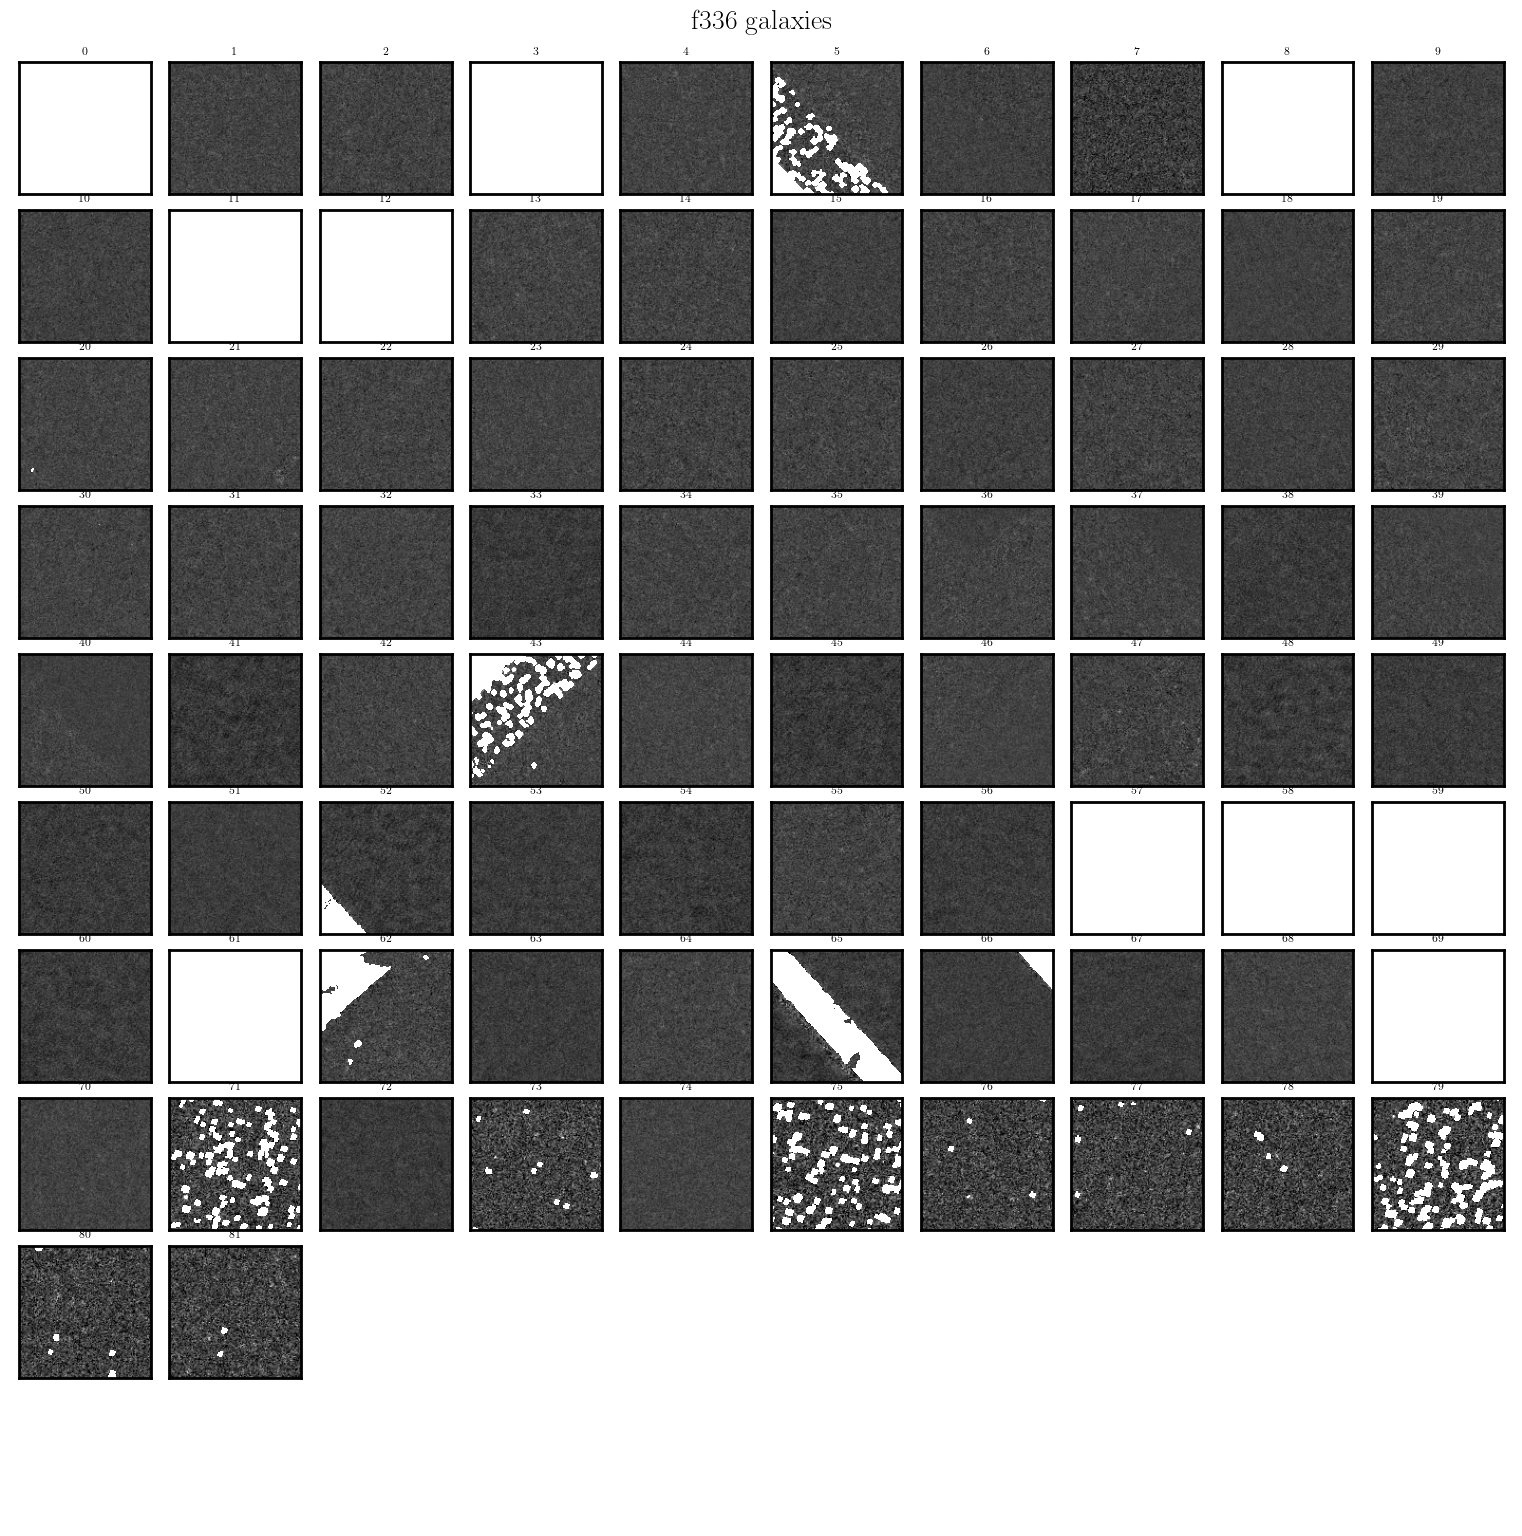

In [26]:
# Define the number of rows and columns for the grid
rows, cols = 10, 10

# Create the figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

fig.suptitle(r'\rm f336 galaxies', fontsize=20, fontweight='bold', y=1.01)
# Flatten the axes array to iterate easily
axes = axes.flatten()

# Calculate global min and max for scaling
all_images = np.array(img_with_source_filt1_arr)  # Assuming this is the list/array of images
vmin = -0.2
vmax =  0.5

# Plot each image on the grid
for i, ax in enumerate(axes):
    if i < len(img_with_source_filt1_arr):
        # Plot the image with consistent scaling
        ax.imshow(np.ma.masked_values(img_with_source_filt1_arr[i], value=0), origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title(r"\rm %d" % i, fontsize=8)

        # Disable ticks
        ax.set_xticks([])  # Disable x-axis ticks
        ax.set_yticks([])  # Disable y-axis ticks
    else:
        # Hide the empty subplots
        ax.axis('off')  # Hide unused slots

# Adjust layout to minimize space between images
plt.tight_layout(pad=-0.1, h_pad=0.01, w_pad=0.01)
#plt.savefig('control_gal_samples_final_f336.jpg', bbox_inches='tight', dpi=220)
# Show the plot
plt.show()


In [27]:
wcs_filt0_arr             = np.delete(wcs_filt0_arr            , comb_err_ind, axis=0)  
wcs_filt1_arr             = np.delete(wcs_filt1_arr            , comb_err_ind, axis=0)
img_only_noise_filt0_arr  = np.delete(img_only_noise_filt0_arr , comb_err_ind, axis=0)
img_with_source_filt0_arr = np.delete(img_with_source_filt0_arr, comb_err_ind, axis=0)
img_with_source_wts0_arr  = np.delete(img_with_source_wts0_arr , comb_err_ind, axis=0)
img_only_noise_wts0_arr   = np.delete(img_only_noise_wts0_arr  , comb_err_ind, axis=0)
img_only_noise_filt1_arr  = np.delete(img_only_noise_filt1_arr , comb_err_ind, axis=0)
img_with_source_filt1_arr = np.delete(img_with_source_filt1_arr, comb_err_ind, axis=0)
img_with_source_wts1_arr  = np.delete(img_with_source_wts1_arr , comb_err_ind, axis=0)
img_only_noise_wts1_arr   = np.delete(img_only_noise_wts1_arr  , comb_err_ind, axis=0)
good_indices              = np.delete(good_indices             , comb_err_ind, axis=0)
mask_arr                  = np.delete(mask_arr                 , comb_err_ind, axis=0)
sample_data               = sample_data[good_indices]

In [28]:
wcs_filt0_arr.shape

(68,)

In [29]:
# cropping f814
cropped_img_with_source_filt0_arr, cropped_wcs_filt0_arr, peak_coords_filt0_arr, indices_range_filt0_arr = [], [], [], []

for i in range(img_only_noise_filt0_arr.shape[0]):
    cropped_image, cropped_wcs, peak_coords, indicies_range = crop_image_centered_on_peak(image_data=img_with_source_filt0_arr[i], wcs=wcs_filt0_arr[i].wcs, crop_size_pixels=100)#crop_size_arcsec=2.45)
    #print(np.where(cropped_image== cropped_image.max()))
    cropped_img_with_source_filt0_arr  .append(cropped_image)
    cropped_wcs_filt0_arr              .append(cropped_wcs  )
    peak_coords_filt0_arr              .append(peak_coords  )
    indices_range_filt0_arr            .append(indicies_range)
cropped_img_with_source_filt0_arr   = np.array(cropped_img_with_source_filt0_arr)
cropped_wcs_filt0_arr               = np.array(cropped_wcs_filt0_arr            )
peak_coords_filt0_arr               = np.array(peak_coords_filt0_arr            )
indices_range_filt0_arr             = np.array(indices_range_filt0_arr          )

In [30]:
cropped_img_with_source_filt0_arr.shape, cropped_wcs_filt0_arr.shape, peak_coords_filt0_arr.shape, indices_range_filt0_arr.shape

((68, 100, 100), (68,), (68,), (68, 2, 2))

In [31]:
for i in range(len(cropped_img_with_source_filt0_arr)):
    x = np.where(img_with_source_filt0_arr[i] == np.nanmax(img_with_source_filt0_arr[i]))
    y = np.where(cropped_img_with_source_filt0_arr[i] == np.nanmax(cropped_img_with_source_filt0_arr[i]))
    print(i, cropped_img_with_source_filt0_arr[i].shape, x, y)

0 (100, 100) (array([61]), array([58])) (array([50]), array([50]))
1 (100, 100) (array([64]), array([64])) (array([50]), array([50]))
2 (100, 100) (array([63]), array([61])) (array([50]), array([50]))
3 (100, 100) (array([66]), array([62])) (array([50]), array([50]))
4 (100, 100) (array([64]), array([60])) (array([50]), array([50]))
5 (100, 100) (array([67]), array([57])) (array([50]), array([50]))
6 (100, 100) (array([64]), array([57])) (array([50]), array([50]))
7 (100, 100) (array([63]), array([60])) (array([50]), array([50]))
8 (100, 100) (array([65]), array([64])) (array([50]), array([50]))
9 (100, 100) (array([62]), array([62])) (array([50]), array([50]))
10 (100, 100) (array([62]), array([59])) (array([50]), array([50]))
11 (100, 100) (array([60]), array([64])) (array([50]), array([50]))
12 (100, 100) (array([68]), array([60])) (array([50]), array([50]))
13 (100, 100) (array([62]), array([61])) (array([50]), array([50]))
14 (100, 100) (array([62]), array([60])) (array([50]), arr

In [32]:
mask_arr.shape

(68, 125, 125)

In [33]:
## cropping original data
def cropp_other_filt_data(data, crop_ind,):    
    
    cropped_arr= []

    for i in range(data.shape[0]):
        y_min, y_max = crop_ind[i][0]
        x_min, x_max = crop_ind[i][1]

        cropped_arr.append(data[i].data[y_min:y_max, x_min:x_max])

    cropped_arr = np.array(cropped_arr)
    
    return cropped_arr

def cropp_other_filt_wcs(data, crop_ind,):    
    
    cropped_arr= []

    for i in range(data.shape[0]):
        y_min, y_max = crop_ind[i][0]
        x_min, x_max = crop_ind[i][1]

        cropped_arr.append(data[i].wcs[y_min:y_max, x_min:x_max])

    cropped_arr = np.array(cropped_arr)
    
    return cropped_arr

cropped_org_data_filt0_arr      = cropp_other_filt_data(data=wcs_filt0_arr, crop_ind=indices_range_filt0_arr)
cropped_org_data_filt1_arr      = cropp_other_filt_data(data=wcs_filt1_arr, crop_ind=indices_range_filt0_arr)
cropped_org_data_wcs_filt0_arr  = cropp_other_filt_wcs(data=wcs_filt0_arr, crop_ind=indices_range_filt0_arr)
cropped_org_data_wcs_filt1_arr  = cropp_other_filt_wcs(data=wcs_filt1_arr, crop_ind=indices_range_filt0_arr)

In [34]:
# cropping f814 wts, noise img
cropped_img_only_noise_filt0_arr  = cropp_other_filt(data=img_only_noise_filt0_arr, crop_ind=indices_range_filt0_arr)
cropped_img_with_source_wts0_arr  = cropp_other_filt(data=img_with_source_wts0_arr, crop_ind=indices_range_filt0_arr)
cropped_img_only_noise_wts0_arr   = cropp_other_filt(data=img_only_noise_wts0_arr , crop_ind=indices_range_filt0_arr)
cropped_mask                      = cropp_other_filt(data=mask_arr,                 crop_ind=indices_range_filt0_arr)

In [35]:
# cropping f336
cropped_img_with_source_filt1_arr  = cropp_other_filt(data=img_with_source_filt1_arr, crop_ind=indices_range_filt0_arr)
cropped_img_only_noise_filt1_arr   = cropp_other_filt(data=img_only_noise_filt1_arr , crop_ind=indices_range_filt0_arr)
cropped_img_with_source_wts1_arr   = cropp_other_filt(data=img_with_source_wts1_arr , crop_ind=indices_range_filt0_arr)
cropped_img_only_noise_wts1_arr    = cropp_other_filt(data=img_only_noise_wts1_arr  , crop_ind=indices_range_filt0_arr)

In [36]:
#cropped_img_with_source_filt0_arr   = np.delete(cropped_img_with_source_filt0_arr, f814_err)
#cropped_wcs_filt0_arr               = np.delete(cropped_wcs_filt0_arr            , f814_err)
#peak_coords_filt0_arr               = np.delete(peak_coords_filt0_arr            , f814_err)
#indices_range_filt0_arr             = np.delete(indices_range_filt0_arr          , f814_err)
#
#cropped_img_only_noise_filt0_arr  = np.delete(cropped_img_only_noise_filt0_arr, f814_err)
#cropped_img_with_source_wts0_arr  = np.delete(cropped_img_with_source_wts0_arr, f814_err)
#cropped_img_only_noise_wts0_arr   = np.delete(cropped_img_only_noise_wts0_arr , f814_err)
#cropped_mask                      = np.delete(cropped_mask                    , f814_err)
#
#cropped_img_with_source_filt1_arr    = np.delete(cropped_img_with_source_filt1_arr , f814_err)
#cropped_img_only_noise_filt1_arr     = np.delete(cropped_img_only_noise_filt1_arr  , f814_err)
#cropped_img_with_source_wts1_arr     = np.delete(cropped_img_with_source_wts1_arr  , f814_err)
#cropped_img_only_noise_wts1_arr      = np.delete(cropped_img_only_noise_wts1_arr   , f814_err)
#


In [37]:
cropped_img_with_source_filt0_arr.shape

(68, 100, 100)

In [38]:
cropped_img_with_source_filt1_arr, per_arr  = fill_mask_arr_gen(image=cropped_img_with_source_filt1_arr, source_mask=cropped_mask)
cropped_img_only_noise_filt1_arr , per_arr  = fill_mask_arr_gen(image=cropped_img_only_noise_filt1_arr , source_mask=cropped_mask)
cropped_img_with_source_wts1_arr , per_arr  = fill_mask_arr_gen(image=cropped_img_with_source_wts1_arr , source_mask=cropped_mask)
cropped_img_only_noise_wts1_arr  , per_arr  = fill_mask_arr_gen(image=cropped_img_only_noise_wts1_arr  , source_mask=cropped_mask)


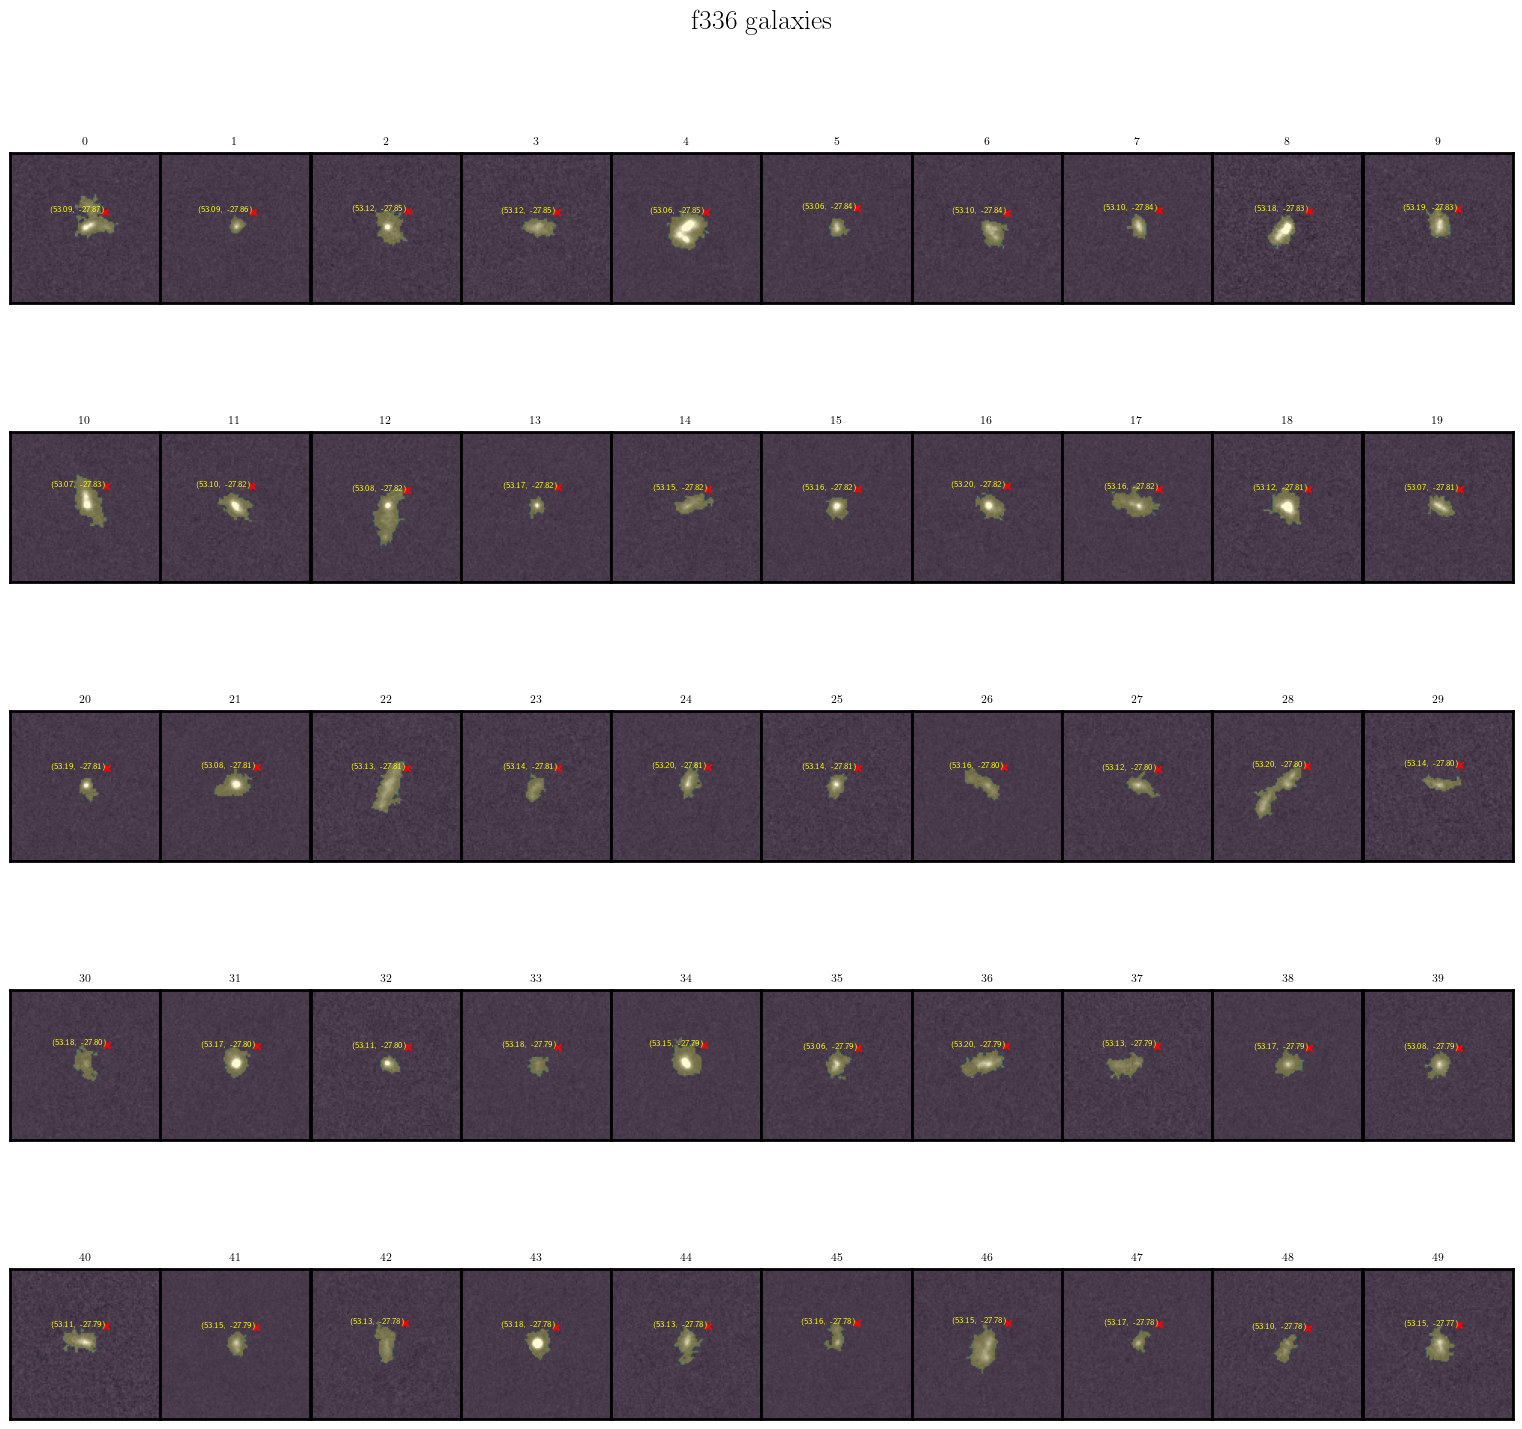

In [39]:
# Define the number of rows and columns for the grid
rows, cols = 5, 10

# Create the figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

fig.suptitle(r'\rm f336 galaxies', fontsize=20, fontweight='bold', y=1.01)

# Flatten the axes array to iterate easily
axes = axes.flatten()

# Global min and max for scaling
vmin, vmax = -0.2, 0.5

# Example RA/Dec values (these must be the same length as your images)
ra_list = sample_data['RA']  # List of RA values in degrees
dec_list = sample_data['dec']  # List of Dec values in degrees

# Plot each image on the grid
for i, ax in enumerate(axes):
    if i < len(img_with_source_filt1_arr):
        # Extract the correct WCS for this image
        wcs = wcs_filt0_arr[i].wcs  # Assuming this is a list of WCS objects

        # Convert RA/Dec to pixel coordinates for this specific WCS
        x_pix, y_pix = wcs.world_to_pixel_values(ra_list[i], dec_list[i])

        # Plot the image with consistent scaling
        ax.imshow(np.ma.masked_equal(cropped_img_with_source_filt0_arr[i], value=0.), 
                  origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
        ax.imshow(cropped_mask[i], origin='lower', alpha=0.2)
        ax.set_title(r"\rm %d" % i, fontsize=8)

        # Overlay converted pixel coordinates
        ax.scatter(x_pix, y_pix, marker='x', color='red', s=20, label="Source")

        # Annotate with RA/Dec values
        ax.annotate(f"({ra_list[i]:.2f}, {dec_list[i]:.2f})", 
                    (x_pix, y_pix), fontsize=6, color='yellow', ha='right')

        # Disable ticks
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.axis('off')  # Hide unused slots

# Adjust layout to minimize space between images
plt.tight_layout(pad=-0.1, h_pad=0.01, w_pad=0.01)
plt.show()


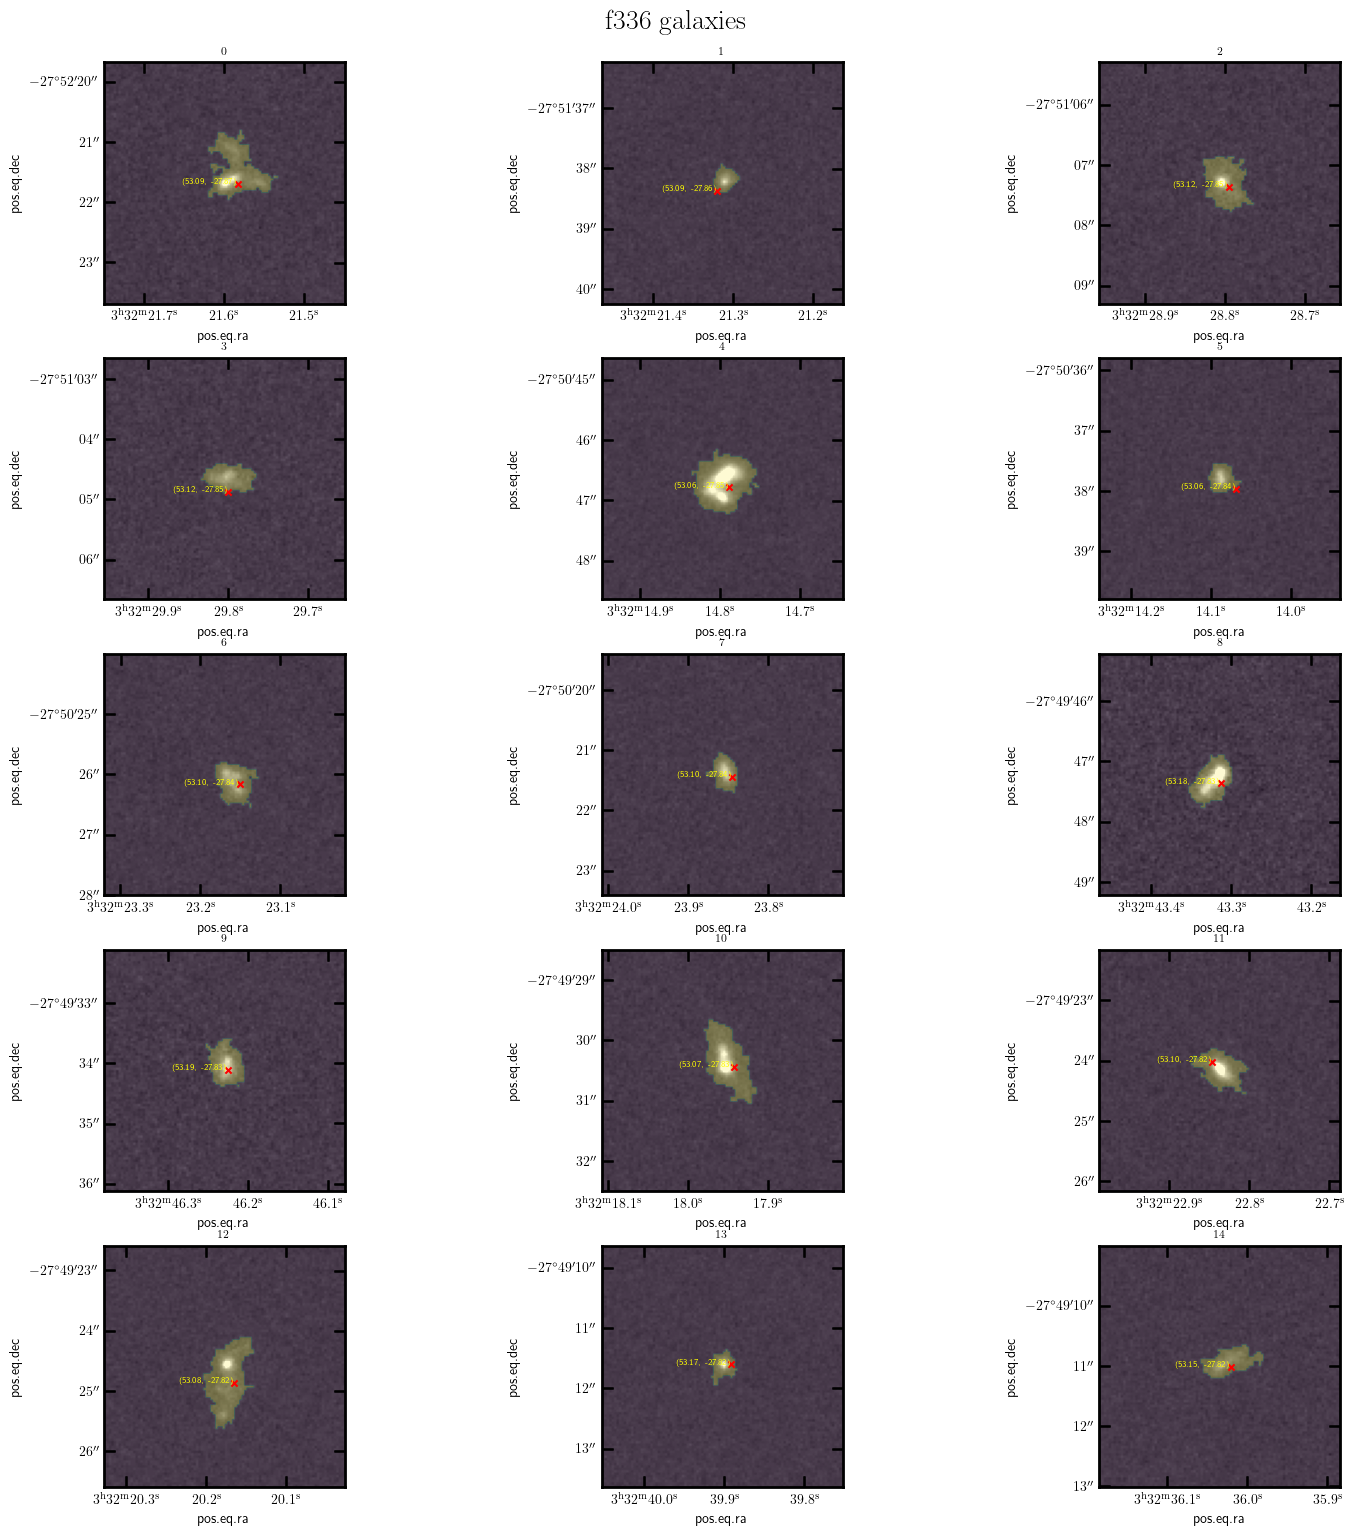

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization.wcsaxes import WCSAxes

# Define the number of rows and columns for the grid
rows, cols = 5, 3

# Create the figure
fig = plt.figure(figsize=(15, 15))
fig.suptitle(r'\rm f336 galaxies', fontsize=20, fontweight='bold', y=1.01)

# Global min and max for scaling
vmin, vmax = -0.2, 0.5

# Example RA/Dec values
ra_list = sample_data['RA']  # List of RA values in degrees
dec_list = sample_data['dec']  # List of Dec values in degrees

# Iterate over images and create individual WCS subplots
for i in range(rows * cols):
    if i < len(img_with_source_filt1_arr):
        # Extract the correct WCS for this image
        wcs = cropped_wcs_filt0_arr[i]  # Assuming this is a list of WCS objects
        
        # Create subplot with WCS projection
        ax = fig.add_subplot(rows, cols, i+1, projection=wcs)

        # Convert RA/Dec to pixel coordinates for this specific WCS
        x_pix, y_pix = wcs.world_to_pixel_values(ra_list[i], dec_list[i])

        # Plot the image with consistent scaling
        ax.imshow(np.ma.masked_equal(cropped_img_with_source_filt0_arr[i], value=0.), 
                  origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
        ax.imshow(cropped_mask[i], origin='lower', alpha=0.2)
        ax.set_title(r"\rm %d" % i, fontsize=8)

        # Overlay converted pixel coordinates
        ax.scatter(x_pix, y_pix, marker='x', color='red', s=20, label="Source")

        # Annotate with RA/Dec values
        ax.annotate(f"({ra_list[i]:.2f}, {dec_list[i]:.2f})", 
                    (x_pix, y_pix), fontsize=6, color='yellow', ha='right')

        # Remove ticks
        ax.set_xticks([], visible=False)
        ax.set_yticks([], visible=False)
    else:
        ax = fig.add_subplot(rows, cols, i+1)  # Empty subplot
        ax.axis('off')  # Hide unused slots

# Adjust layout to minimize space between images
plt.tight_layout(pad=-0.1, h_pad=0.001, w_pad=0.01)
plt.show()


In [47]:
org_data_stacked_filter0.shape, stacked_filter0.shape

((68, 100, 100), (68, 125, 125))

In [51]:
# Assuming your existing variables like wcs_, wcs_data_, and image stacking are already defined

org_data_stacked_filter0 = np.stack(cropped_org_data_filt0_arr, axis=0) 
org_data_stacked_filter1 = np.stack(cropped_org_data_filt1_arr, axis=0)
org_wcs_stacked_filter0n = np.stack(cropped_org_data_wcs_filt0_arr, axis=0)
org_wcs_stacked_filter1n = np.stack(cropped_org_data_wcs_filt1_arr, axis=0)

stacked_filter0 =  np.stack(cropped_img_with_source_filt0_arr, axis=0)  # (n, 100, 100)
stacked_filter1 =  np.stack(cropped_img_with_source_filt1_arr, axis=0)
stacked_filter0n = np.stack(cropped_img_only_noise_filt0_arr, axis=0)
stacked_filter1n = np.stack(cropped_img_only_noise_filt1_arr, axis=0)
stacked_filter0w = np.stack(cropped_img_with_source_wts0_arr, axis=0)
stacked_filter1w = np.stack(cropped_img_with_source_wts1_arr, axis=0)

# Primary HDU (No WCS header)
primary_hdu = fits.PrimaryHDU(org_data_stacked_filter0)
primary_hdu.header['EXTNAME'] = 'F814-original'

f336_hdu = fits.ImageHDU(org_data_stacked_filter1)
f336_hdu.header['EXTNAME'] = 'F336-original'


# Mask HDU
mask_hdu = fits.ImageHDU(cropped_mask.astype(np.uint8))
mask_hdu.header['EXTNAME'] = 'F814-segments'

# Create ImageHDUs with the stacked arrays (without WCS headers)
filter0_hdu = fits.ImageHDU(stacked_filter0)
filter0_hdu.header['EXTNAME'] = 'F814'

filter1_hdu = fits.ImageHDU(stacked_filter1)
filter1_hdu.header['EXTNAME'] = 'F336'

filter0n_hdu = fits.ImageHDU(stacked_filter0n)
filter0n_hdu.header['EXTNAME'] = 'F814-background'

filter1n_hdu = fits.ImageHDU(stacked_filter1n)
filter1n_hdu.header['EXTNAME'] = 'F336-background'

filter0w_hdu = fits.ImageHDU(stacked_filter0w)
filter0w_hdu.header['EXTNAME'] = 'F814-weights'

filter1w_hdu = fits.ImageHDU(stacked_filter1w)
filter1w_hdu.header['EXTNAME'] = 'F336-weights'

# Create an HDU for each WCS object and add it to the list of HDUs
wcs_hdus = []
for i in range(len(cropped_wcs_filt0_arr)):  # Dynamically based on the length of the data
    wcs_hdu = fits.ImageHDU(np.zeros((1, 1)))  # Placeholder data for WCS HDUs
    wcs_hdu.header['EXTNAME'] = f'WCS-sourceID-%d'%sample_data['id'][i]
    wcs_hdu.header.update(cropped_wcs_filt0_arr[i].to_header())  # Add WCS header
    wcs_hdus.append(wcs_hdu)

# Create HDUs for each field of the structured array
structured_data_hdus = []
for field_name in sample_data.dtype.names:
    field_data = sample_data[field_name]
    field_hdu = fits.ImageHDU(field_data)
    field_hdu.header['EXTNAME'] = field_name  # Use field name as EXTNAME
    structured_data_hdus.append(field_hdu)

# Create HDU list and save to a FITS file
hdul = fits.HDUList([
    primary_hdu, f336_hdu, mask_hdu, filter0_hdu, filter1_hdu, 
    filter0n_hdu, filter1n_hdu, filter0w_hdu, filter1w_hdu
] + wcs_hdus + structured_data_hdus)  # Add WCS HDUs and structured data HDUs

hdul.writeto('/media/himanshu/MyHDD/data_galaxy_evolution/process_data/Control_data_final.fits', overwrite=True)

print("FITS file 'Control_final_with_structured_data.fits' created successfully.")


FITS file 'Control_final_with_structured_data.fits' created successfully.


In [ ]:
# Define the number of rows and columns for the grid
rows, cols = 10, 10

# Create the figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
fig.suptitle(r'\rm f814', fontsize=15, fontweight='bold', y=0.97)

# Flatten the axes array to iterate easily
axes = axes.flatten()

# Calculate global min and max for scaling
all_images = np.array(cropped_img_with_source_filt0_arr)  # Assuming this is the list/array of images
vmin = -0.2
vmax = 0.5

# Plot each image on the grid
for i, ax in enumerate(axes):
    if i < len(cropped_img_with_source_filt0_arr):
        # Plot the image with consistent scaling
        ax.imshow(np.ma.masked_values(cropped_img_with_source_filt0_arr[i], value=0.0), origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
        
        # Add Source ID text inside each image
        source_id = sample_data[good_indices]['id'][i]  # Get the source ID for the image
        ax.text(0.5, 0.9, r"\rm zfourge~ID: %d" % source_id, color='white', fontsize=10, ha='center', va='center',
                transform=ax.transAxes)
        
        # Disable ticks
        ax.set_xticks([])  # Disable x-axis ticks
        ax.set_yticks([])  # Disable y-axis ticks
    else:
        # Hide the empty subplots
        ax.axis('off')  # Hide unused slots

# Adjust layout to minimize space between images
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.01, wspace=0.01)

# Save the figure with tight bounding box
plt.savefig('control_gal_samples_final_f814.jpg', bbox_inches='tight', dpi=220)

# Show the plot
plt.show()


In [ ]:
# Define the number of rows and columns for the grid
rows, cols = 10, 10

# Create the figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

fig.suptitle(r'\rm final segment', fontsize=20, fontweight='bold', y=1.01)
# Flatten the axes array to iterate easily
axes = axes.flatten()

# Calculate global min and max for scaling
all_images = np.array(cropped_img_with_source_filt0_arr)  # Assuming this is the list/array of images
vmin = -0.2
vmax =  0.5

# Plot each image on the grid
for i, ax in enumerate(axes):
    if i < len(cropped_img_with_source_filt0_arr):
        # Plot the image with consistent scaling
        ax.imshow(cropped_img_with_source_wts0_arr[i], origin='lower', cmap='gray', )
        #ax.set_title(r"\rm Source ID: %d" % sample_data[good_indices]['id'][i], fontsize=8)

        # Disable ticks
        ax.set_xticks([])  # Disable x-axis ticks
        ax.set_yticks([])  # Disable y-axis ticks
    else:
        # Hide the empty subplots
        ax.axis('off')  # Hide unused slots

# Adjust layout to minimize space between images
plt.tight_layout(pad=-0.1, h_pad=0.01, w_pad=0.01)
plt.savefig('control_gal_samples_mask_final.jpg', bbox_inches='tight', dpi=220)
# Show the plot
plt.show()


In [ ]:
# Define the number of rows and columns for the grid
rows, cols = 10, 10

# Create the figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
fig.suptitle(r'\rm f336', fontsize=15, fontweight='bold', y=0.97)

# Flatten the axes array to iterate easily
axes = axes.flatten()

# Calculate global min and max for scaling
all_images = np.array(cropped_img_with_source_filt1_arr)  # Assuming this is the list/array of images
vmin = -0.2
vmax = 0.5

# Plot each image on the grid
for i, ax in enumerate(axes):
    if i < len(cropped_img_with_source_filt1_arr):
        # Plot the image with consistent scaling
        ax.imshow(np.ma.masked_values(cropped_img_with_source_filt1_arr[i], value=0), origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
        
        # Add Source ID text inside each image
        source_id = sample_data[good_indices]['id'][i]  # Get the source ID for the image
        ax.text(0.5, 0.9, r"\rm zfourge~ID: %d" % source_id, color='white', fontsize=10, ha='center', va='center',
                transform=ax.transAxes)
        
        # Disable ticks
        ax.set_xticks([])  # Disable x-axis ticks
        ax.set_yticks([])  # Disable y-axis ticks
    else:
        # Hide the empty subplots
        ax.axis('off')  # Hide unused slots

# Adjust layout to minimize space between images
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.01, wspace=0.01)

# Save the figure with tight bounding box
plt.savefig('control_gal_samples_final_f336.jpg', bbox_inches='tight', dpi=220)

# Show the plot
plt.show()


In [ ]:
# Define the number of rows and columns for the grid
rows, cols = 10, 10

# Create the figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
fig.suptitle(r'\rm f336 with segment overlay', fontsize=15, fontweight='bold', y=0.97)

# Flatten the axes array to iterate easily
axes = axes.flatten()

# Calculate global min and max for scaling
all_images = np.array(cropped_img_with_source_filt1_arr)  # Assuming this is the list/array of images
vmin = -0.2
vmax = 0.5

# Plot each image on the grid
for i, ax in enumerate(axes):
    if i < len(cropped_img_with_source_filt1_arr):
        # Plot the image with consistent scaling
        ax.imshow(np.ma.masked_values(cropped_img_with_source_filt1_arr[i], value=0.), origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
        ax.imshow(cropped_mask[i], origin='lower', cmap='gray', alpha=0.2)
        # Add Source ID text inside each image
        source_id = sample_data[good_indices]['id'][i]  # Get the source ID for the image
        ax.text(0.5, 0.9, r"\rm zfourge~ID: %d" % source_id, color='white', fontsize=10, ha='center', va='center',
                transform=ax.transAxes)
        
        # Disable ticks
        ax.set_xticks([])  # Disable x-axis ticks
        ax.set_yticks([])  # Disable y-axis ticks
    else:
        # Hide the empty subplots
        ax.axis('off')  # Hide unused slots

# Adjust layout to minimize space between images
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.01, wspace=0.01)

# Save the figure with tight bounding box
plt.savefig('control_gal_samples_final_f336_w_segment_overlay.jpg', bbox_inches='tight', dpi=220)

# Show the plot
plt.show()


In [ ]:
## final stacking
def get_wtd_mean(data, wts):
    wtd_mean = np.nansum(data*wts, axis=0)/ np.nansum(wts, axis=0)
    return wtd_mean

def inverse_variance_weighted_mean(images, noise):
    """
    Compute the inverse variance-weighted mean of a stack of images.

    Parameters:
    - images: np.ndarray, shape (25, 100, 100)
      The stack of images.
    - noise: np.ndarray, shape (25, 100, 100)
      The corresponding noise values (standard deviation) for each image.

    Returns:
    - weighted_mean: np.ndarray, shape (100, 100)
      The inverse variance-weighted mean of the input images.
    """
    # Calculate the inverse variance (1 / noise^2)
    inverse_variance = 1. / (noise**2)
    
    # Compute the numerator: sum(image / noise^2)
    numerator = np.nansum(images * inverse_variance, axis=0)
    
    # Compute the denominator: sum(1 / noise^2)
    denominator = np.nansum(inverse_variance, axis=0)
    
    # Avoid division by zero
    #denominator[denominator == 0] = np.nan
    
    # Calculate the weighted mean
    weighted_mean = numerator / denominator
    
    # Handle potential NaN values
    #weighted_mean = np.nan_to_num(weighted_mean)
    
    return weighted_mean

#

In [42]:
cropped_img_with_source_filt0_arr_wtd_mean = get_wtd_mean(data=cropped_img_with_source_filt0_arr, wts=cropped_img_with_source_wts0_arr)
cropped_img_with_source_filt1_arr_wtd_mean = get_wtd_mean(data=cropped_img_with_source_filt1_arr, wts=cropped_img_with_source_wts1_arr)

#cropped_img_with_source_filt0_arr_wtd_mean = get_wtd_mean(data=cropped_img_with_source_filt0_arr, wts=cropped_img_with_source_wts0_arr)

cropped_img_with_source_filt0_arr_var_wtd_mean = inverse_variance_weighted_mean(images=cropped_img_with_source_filt0_arr, noise=cropped_img_only_noise_filt0_arr)
cropped_img_with_source_filt1_arr_var_wtd_mean = inverse_variance_weighted_mean(images=cropped_img_with_source_filt1_arr, noise=np.maximum(cropped_img_only_noise_filt1_arr, 1e-8))


#cropped_img_with_source_filt0_arr 
#cropped_wcs_filt0_arr             
#peak_coords_filt0_arr             
#indices_range_filt0_arr           
#
#cropped_img_only_noise_filt0_arr  
#cropped_img_with_source_wts0_arr  
#cropped_img_only_noise_wts0_arr   
#cropped_mask                      
#
#cropped_img_with_source_filt1_arr 
#cropped_img_only_noise_filt1_arr  
#cropped_img_with_source_wts1_arr  
#cropped_img_only_noise_wts1_arr   

NameError: name 'get_wtd_mean' is not defined

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set up the figure
plt.figure(figsize=(8, 5))
plt.suptitle(r'\rm Weighted Mean Stacking (control sample)', size=18, y=1.02)  # Adjust y for better spacing

# Plot the first weighted mean stacked image
ax1 = plt.subplot(121)
plt.title(r'\rm f814', size=15)
im1 = ax1.imshow(np.nanmean(cropped_img_with_source_filt0_arr, axis=0), vmin=-0.1, vmax=0.1, origin='lower', cmap='cividis')

# Add colour bar for the first subplot with full width
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.4)  # Adjust size and padding
cb1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cb1.set_label(r'$\rm Flux-density (10 \times nJy)$', fontsize=15)

# Plot the second weighted mean stacked image
ax2 = plt.subplot(122)
plt.title(r'\rm f336', size=15)
im2 = ax2.imshow(np.nanmean(cropped_img_with_source_filt1_arr, axis=0), vmin=-0.1, vmax=0.1, origin='lower', cmap='gray')

# Add colour bar for the second subplot with full width
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.4)  # Adjust size and padding
cb2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cb2.set_label(r'$\rm Flux-density (10 \times nJy)$', fontsize=15)

# Adjust layout to ensure spacing is optimal
plt.tight_layout()#rect=[0, 0, 1, 0.95])  # Adjust the rect to leave space for the suptitle

# Uncomment to save the figure
plt.savefig('wtd_mean_stacked.jpg', bbox_inches='tight', dpi=120)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set up the figure
plt.figure(figsize=(8, 5))
plt.suptitle(r'\rm Weighted Mean Stacking (control sample)', size=18, y=1.02)  # Adjust y for better spacing

# Plot the first weighted mean stacked image
ax1 = plt.subplot(121)
plt.title(r'\rm f814', size=15)
im1 = ax1.imshow(cropped_img_with_source_filt0_arr_wtd_mean, vmin=-0.50, vmax=0.50, origin='lower', cmap='gray')

# Add colour bar for the first subplot with full width
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.4)  # Adjust size and padding
cb1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cb1.set_label(r'$\rm Flux-density (10 \times nJy)$', fontsize=15)

# Plot the second weighted mean stacked image
ax2 = plt.subplot(122)
plt.title(r'\rm f336', size=15)
im2 = ax2.imshow(cropped_img_with_source_filt1_arr_wtd_mean, vmin=-0.50, vmax=0.50, origin='lower', cmap='gray')

# Add colour bar for the second subplot with full width
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.4)  # Adjust size and padding
cb2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cb2.set_label(r'$\rm Flux-density (10 \times nJy)$', fontsize=15)

# Adjust layout to ensure spacing is optimal
plt.tight_layout()#rect=[0, 0, 1, 0.95])  # Adjust the rect to leave space for the suptitle

# Uncomment to save the figure
plt.savefig('wtd_mean_stacked.jpg', bbox_inches='tight', dpi=120)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set up the figure
plt.figure(figsize=(8, 5))
plt.suptitle(r'\rm Inverse Variance Weighted Mean Stacking (control sample)', size=18, y=1.02)  # Adjust y for better spacing

# Plot the first weighted mean stacked image
ax1 = plt.subplot(121)
plt.title(r'\rm f814', size=15)
im1 = ax1.imshow(cropped_img_with_source_filt0_arr_var_wtd_mean, vmin=-0.1, vmax=0.1, origin='lower', cmap='gray')

# Add colour bar for the first subplot with full width
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.4)  # Adjust size and padding
cb1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cb1.set_label(r'$\rm Flux-density (10 \times nJy)$', fontsize=15)

# Plot the second weighted mean stacked image
ax2 = plt.subplot(122)
plt.title(r'\rm f336', size=15)
im2 = ax2.imshow(cropped_img_with_source_filt1_arr_var_wtd_mean, vmin=-0.10, vmax=0.10, origin='lower', cmap='gray')

# Add colour bar for the second subplot with full width
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.4)  # Adjust size and padding
cb2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cb2.set_label(r'$\rm Flux-density (10 \times nJy)$', fontsize=15)

# Adjust layout to ensure spacing is optimal
plt.tight_layout()#rect=[0, 0, 1, 0.95])  # Adjust the rect to leave space for the suptitle

# Uncomment to save the figure
plt.savefig('inv_var_wtd_mean_stacked.jpg', bbox_inches='tight', dpi=120)
plt.show()


In [ ]:
cropped_img_with_source_filt0_arr_masked = np.ma.masked_array(cropped_img_with_source_filt0_arr, mask=~cropped_mask)
cropped_img_with_source_filt1_arr_masked = np.ma.masked_array(cropped_img_with_source_filt1_arr, mask=~cropped_mask)

cropped_img_with_source_wts0_arr_masked  = np.ma.masked_array(cropped_img_with_source_wts0_arr , mask=~cropped_mask)
cropped_img_with_source_wts1_arr_masked  = np.ma.masked_array(cropped_img_with_source_wts1_arr , mask=~cropped_mask)

cropped_img_only_noise_filt0_arr_masked  = np.ma.masked_array(cropped_img_only_noise_filt0_arr , mask=~cropped_mask)
cropped_img_only_noise_filt1_arr_masked  = np.ma.masked_array(cropped_img_only_noise_filt1_arr , mask=~cropped_mask)

In [ ]:
cropped_img_with_source_filt0_arr_wtd_mean_masked = get_wtd_mean(data=cropped_img_with_source_filt0_arr_masked, wts=cropped_img_with_source_wts0_arr_masked)
cropped_img_with_source_filt1_arr_wtd_mean_masked = get_wtd_mean(data=cropped_img_with_source_filt1_arr_masked, wts=cropped_img_with_source_wts1_arr_masked)


cropped_img_with_source_filt0_arr_var_wtd_mean_masked = inverse_variance_weighted_mean(images=cropped_img_with_source_filt0_arr_masked, noise=cropped_img_only_noise_filt0_arr_masked)
cropped_img_with_source_filt1_arr_var_wtd_mean_masked = inverse_variance_weighted_mean(images=cropped_img_with_source_filt1_arr_masked, noise=cropped_img_only_noise_filt1_arr_masked)



In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set up the figure
plt.figure(figsize=(8, 5))
plt.suptitle(r'\rm Weighted Mean Stacking (source only)- control sample', size=18, y=1.02)  # Adjust y for better spacing

# Plot the first weighted mean stacked image
ax1 = plt.subplot(121)
plt.title(r'\rm f814', size=15)
im1 = ax1.imshow(cropped_img_with_source_filt0_arr_wtd_mean_masked, vmin=-0.50, vmax=0.50, origin='lower', cmap='gray')

# Add colour bar for the first subplot with full width
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.4)  # Adjust size and padding
cb1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cb1.set_label(r'$\rm Flux-density (10 \times nJy)$', fontsize=15)

# Plot the second weighted mean stacked image
ax2 = plt.subplot(122)
plt.title(r'\rm f336', size=15)
im2 = ax2.imshow(cropped_img_with_source_filt1_arr_wtd_mean_masked, vmin=-0.50, vmax=0.50, origin='lower', cmap='gray')

# Add colour bar for the second subplot with full width
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.4)  # Adjust size and padding
cb2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cb2.set_label(r'$\rm Flux-density (10 \times nJy)$', fontsize=15)

# Adjust layout to ensure spacing is optimal
plt.tight_layout()#rect=[0, 0, 1, 0.95])  # Adjust the rect to leave space for the suptitle

# Uncomment to save the figure
plt.savefig('wtd_mean_stacked_source_only.jpg', bbox_inches='tight', dpi=120)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set up the figure
plt.figure(figsize=(8, 5))
plt.suptitle(r'\rm Inverse Variance Weighted Mean Stacking (source only)- control sample', size=18, y=1.02)  # Adjust y for better spacing

# Plot the first weighted mean stacked image
ax1 = plt.subplot(121)
plt.title(r'\rm f814', size=15)
im1 = ax1.imshow(cropped_img_with_source_filt0_arr_var_wtd_mean_masked, vmin=-0.50, vmax=0.50, origin='lower', cmap='gray')

# Add colour bar for the first subplot with full width
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.4)  # Adjust size and padding
cb1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cb1.set_label(r'$\rm Flux-density (10 \times nJy)$', fontsize=15)

# Plot the second weighted mean stacked image
ax2 = plt.subplot(122)
plt.title(r'\rm f336', size=15)
im2 = ax2.imshow(cropped_img_with_source_filt1_arr_var_wtd_mean_masked, vmin=-0.50, vmax=0.50, origin='lower', cmap='gray')

# Add colour bar for the second subplot with full width
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.4)  # Adjust size and padding
cb2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cb2.set_label(r'$\rm Flux-density (10 \times nJy)$', fontsize=15)

# Adjust layout to ensure spacing is optimal
plt.tight_layout()#rect=[0, 0, 1, 0.95])  # Adjust the rect to leave space for the suptitle

# Uncomment to save the figure
plt.savefig('inv_var_wtd_mean_stacked_source_only.jpg', bbox_inches='tight', dpi=120)
plt.show()


In [ ]:
cropped_img_with_source_filt0_arr_masked, cropped_img_with_source_filt1_arr_masked

In [ ]:
cropped_img_with_source_filt0_arr_masked.shape

In [ ]:
cropped_img_with_source_filt0_arr_masked.reshape(cropped_img_with_source_filt0_arr_masked.shape[0], -1).shape

In [ ]:
def sum_flux(data):
    data = data.reshape(data.shape[0], -1)
    return np.sum(data, axis=-1)

In [ ]:
f814_flux = sum_flux(data=cropped_img_with_source_filt0_arr_masked)
f336_flux = sum_flux(data=cropped_img_with_source_filt1_arr_masked)

mean_f814_noise = np.sqrt(np.nanmean(img_only_noise_filt0_arr.reshape(img_only_noise_filt0_arr.shape[0], -1)**2, axis=-1))
mean_f336_noise = np.sqrt(np.nanmean(img_only_noise_filt1_arr.reshape(img_only_noise_filt1_arr.shape[0], -1)**2, axis=-1))

In [ ]:
f336_flux.shape

In [ ]:
plt.figure(figsize=(6,4))
#plt.yscale('symlog')
plt.title(r'\rm Control sample', size=18)
plt.ylabel(r'\rm Flux-density [10 nJy]', size=18)
plt.xlabel(r'\rm galaxy count', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.errorbar(x = np.arange(f814_flux.size), y = f814_flux, yerr = mean_f814_noise, marker = 'o', ls=':', markersize=4, label=r'$\rm f814 (mean~ flux)$')
plt.errorbar(x = np.arange(f336_flux.size), y = f336_flux, yerr = mean_f336_noise, marker = 'o', ls=':', markersize=4, label=r'$\rm f336 (mean~flux)$')
plt.legend(loc='best', fontsize=15)
plt.savefig('flux_compare_control.jpg', bbox_inches='tight', dpi=120)
plt.show()

In [ ]:
plt.figure(figsize=(7, 6))

# Plot the first histogram with filled bars
plt.hist(
    flux_control_336 , 
    density=True, bins=10, alpha=0.7, 
    label=r'$\rm f336$', color='C0'
)

# Plot the second histogram with only boundaries
plt.hist(
    flux_control_814, 
    density=True, bins=10, histtype='step', 
    label=r'$\rm f814$', color='C1', linewidth=3
)
plt.xticks(size=15)
plt.yticks(size=15)
# Add labels, legend, and title
plt.xlabel(r'$\rm Flux -Density (10 nJy)$', fontsize=14)
plt.ylabel(r'$\rm Probability \ Density$', fontsize=14)
plt.title(r'$\rm Flux \ \ Comparison$', fontsize=16)
plt.legend(loc='best', fontsize=15)

# Adjust layout for better appearance
plt.tight_layout()

# Save and display the figure
plt.savefig('flux_ratio_histogram_control.jpg', dpi=120, bbox_inches='tight')
plt.show()


In [ ]:
np.savetxt('f814_flux_control'      , f814_flux      )
np.savetxt('f814_flux_noise_control', mean_f814_noise)

np.savetxt('f336_flux_control'      , f336_flux      )
np.savetxt('f336_flux_noise_control', mean_f336_noise)

In [ ]:
flux_eelgs_814  = np.loadtxt('f814_flux_eelgs'      ,)
flux_eelgs_814n = np.loadtxt('f814_flux_noise_eelgs',)
flux_eelgs_336  = np.loadtxt('f336_flux_eelgs'      ,)
flux_eelgs_336n = np.loadtxt('f336_flux_noise_eelgs',)

flux_control_814  = np.loadtxt('f814_flux_control'      ,)
flux_control_814n = np.loadtxt('f814_flux_noise_control',)
flux_control_336  = np.loadtxt('f336_flux_control'      ,)
flux_control_336n = np.loadtxt('f336_flux_noise_control',)

In [ ]:
plt.plot(flux_eelgs_336/flux_eelgs_814)
plt.plot(flux_control_336/flux_control_814)

In [ ]:
plt.figure(figsize=(7, 6))

# Plot the first histogram with filled bars
plt.hist(
    flux_control_336 / flux_control_814, 
    density=True, bins=8, alpha=0.7, 
    label=r'$\rm Control$', color='C0'
)

# Plot the second histogram with only boundaries
#plt.hist(
#    flux_eelgs_336 / flux_eelgs_814, 
#    density=True, bins=8, histtype='step', 
#    label=r'$\rm EELGs$', color='C1', linewidth=3
#)
plt.xticks(size=15)
plt.yticks(size=15)
# Add labels, legend, and title
plt.xlabel(r'$\rm Flux \ Ratio \ (f336/f814)$', fontsize=14)
plt.ylabel(r'$\rm Probability \ Density$', fontsize=14)
plt.title(r'$\rm Flux \ Ratio \ Comparison$', fontsize=16)
plt.legend(loc='best', fontsize=15)

# Adjust layout for better appearance
plt.tight_layout()

# Save and display the figure
plt.savefig('flux_ratio_histogram_control.jpg', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
cropped_img_only_noise_filt0_arr.reshape()

In [ ]:
plt.hist(np.nanstd(cropped_img_only_noise_filt0_arr.reshape(68,-1), axis=0))

In [ ]:
plt.imshow(cropped_img_only_noise_filt0_arr[0])